## Data extraction and visualizing

- Merging data from other files
- Read the data from Archigos excel document/dta data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative to set svg for newer versions
%matplotlib inline


# Showing all the details of results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# %matplotlib qt

In [45]:
# Read the original dta(Stata) data download from Archigos website.
# load the data
datafile = './../Data/Archigos_4.1_stata14.dta'
data = pd.read_stata(datafile)

# Startdate is better than eindate, enddate is better than eoutdate
# Change the data type of startdate and enddate to datatime
data['startdate'] = data['startdate'].astype('datetime64[ns]')
data['enddate'] = data['enddate'].astype('datetime64[ns]')
data['yrbegin'] = pd.DatetimeIndex(data['startdate']).year
data['yrend'] = pd.DatetimeIndex(data['enddate']).year

data['yrend'] = np.where(data['yrbegin']==data['yrend'], data['yrend'] + 1, data['yrend'])

# Import the data about countries grouped by three categories: Autocracy, Anocracy, Democracy
data_deau = pd.read_excel('./../Data/DeorAu_group.xlsx')

# load another excel file mpd2020 with gdppc and pop
data_mpd2020 = pd.read_excel('./../Data/mpd2020.xlsx', 'Full data')

# Combine data_deau with data_leader with key id=countries
# Rename the Country-id to idacr in data_deau
data_deau = data_deau.rename({'Country-id': 'idacr'}, axis='columns')
data_leader_deau = pd.merge(data, data_deau, how ='left', on ='idacr')

# Rename the countrycode to idacr in data_mpd2020
# Rename the year in gdppc to yrend to merge data
data_mpd2020 = data_mpd2020.rename({'countrycode': 'idacr', 'year': 'yrend'}, axis='columns')

# Change the float to int
data_leader_deau['yrend'] = data_leader_deau['yrend'].fillna(0.0).astype(int)
data_leader_deau['yrbegin'] = data_leader_deau['yrbegin'].fillna(0.0).astype(int)

# Combine data_leaders_deau with data_mpd2020 with key idacr and year
data_leader_deau_gdp = pd.merge(data_leader_deau, data_mpd2020, how ='left', on =['idacr', 'yrend'])

# Rename the gdppc to end_gdppc in data_leaders_deau_gdp
data_leader_deau_gdp = data_leader_deau_gdp.rename({'gdppc': 'end_gdppc'}, axis='columns')

data_gdp = pd.read_excel('./../Data/data_gdp.xlsx')
data_gdp = data_gdp.rename({'year': 'yrbegin'}, axis='columns')
data_all = pd.merge(data_leader_deau_gdp, data_gdp, how ='left', on =['idacr', 'yrbegin'])

# Rename the gdppc to begin_gdppc in data_all
data_all = data_all.rename({'gdppc': 'begin_gdppc'}, axis='columns')

# Remane the Polity datasets IV number[11][12] to Polity
data_all = data_all.rename({'Polity datasets IV number[11][12]': 'Polity'}, axis='columns')

# Rename the pop_y to pop in data_all
data_all = data_all.rename({'pop_x': 'pop'}, axis='columns')

# Calculate the leaders' age, when they first into power
# See the characteristics of yrborn, there is something wrong in the data. 
# Because I change the data type of yrborn, from int to datetime.

# age= yrbegin- yrborn
data_all['age'] = data_all['yrbegin'] - data_all['yrborn']

C:\Users\DELL\AppData\Local\Temp\ipykernel_9404\1110392424.py:4: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data = pd.read_stata(datafile)


## Calculate their tenure
 
- Calculate the tenure
- Check the data about our data about tenure 
- Delete tenure < 1
- Group the data by leaders and sum their tenure together ？？

In [47]:
import datetime

# tenure= enddate or eoutdate - startdate  or  eindate (Unit: years)
# if enddate is null, it has two possibilities: 
# 1. leader is still in office, use the date now; 2. not available.  

data_all['startdate'] = pd.to_datetime(data_all['startdate']).dt.date
data_all['enddate'] = pd.to_datetime(data_all['enddate']).dt.date

data_all['enddate'] = np.where(data_all['enddate'].isnull(),
                                datetime.datetime.now().date(),
                                data_all['enddate'])

data_all['tenure'] = (data_all['enddate'] - data_all['startdate'])/np.timedelta64(1, 'Y')

# Add tenure to the excel grouped by leaders
# Some leaders may have more than one term
# Tenure: merge the duplicates and sum the tenure.
# data_all=data_all.groupby(['leader']).sum()

In [48]:
# calulate the growth rate


data_all['growth_rate'] = (data_all['end_gdppc'] / data_all['begin_gdppc'] - 1) / np.trunc(data_all['tenure'] + 1)

data_all.dropna(subset = ['growth_rate'], inplace=True)

data_all['growth_rate'].describe()

count    1448.000000
mean        0.020958
std         0.069219
min        -0.314587
25%         0.000000
50%         0.017443
75%         0.038417
max         0.794453
Name: growth_rate, dtype: float64

In [49]:
data_all.columns

Index(['obsid', 'leadid', 'ccode', 'idacr', 'leader', 'startdate', 'eindate',
       'enddate', 'eoutdate', 'entry', 'exit', 'exitcode', 'prevtimesinoffice',
       'posttenurefate', 'gender', 'yrborn', 'yrdied', 'borndate',
       'ebirthdate', 'deathdate', 'edeathdate', 'dbpediauri', 'numentry',
       'numexit', 'numexitcode', 'numposttenurefate', 'fties', 'ftcur',
       'yrbegin', 'yrend', 'Country', 'Democracy', 'Autocracy', 'Polity',
       'Polity datasets IV category', 'country', 'end_gdppc', 'pop',
       'begin_gdppc', 'pop_y', 'age', 'tenure', 'growth_rate'],
      dtype='object')

<AxesSubplot: xlabel='ftcur', ylabel='Count'>

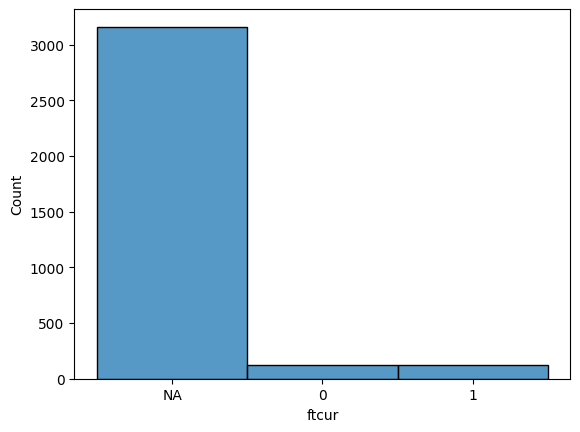

In [46]:
sns.histplot(data_all.ftcur)

<AxesSubplot: xlabel='posttenurefate', ylabel='Count'>

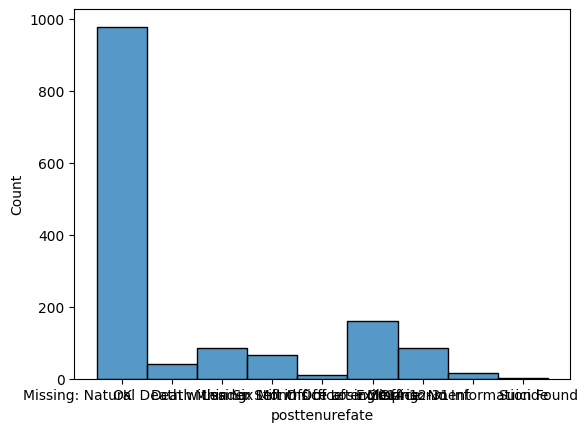

In [40]:
sns.histplot(data_all.posttenurefate)

## Data cleaning

### Delete the irrelevant data with irrelevant columns

In [50]:
# 'country_x','country_y'
data_all.drop(columns=['obsid',
                   'leadid',
                   'idacr',
                   'startdate',
                   'eindate',
                   'enddate',
                   'eoutdate',
                   'borndate',
                   'ebirthdate',
                   'deathdate',
                   'edeathdate',
                   'dbpediauri',
                   'Democracy',
                   'Autocracy',
                  'Country',
                  'pop_y',
                  'Polity datasets IV category'], inplace=True)

In [51]:
data_all.columns

Index(['ccode', 'leader', 'entry', 'exit', 'exitcode', 'prevtimesinoffice',
       'posttenurefate', 'gender', 'yrborn', 'yrdied', 'numentry', 'numexit',
       'numexitcode', 'numposttenurefate', 'fties', 'ftcur', 'yrbegin',
       'yrend', 'Polity', 'country', 'end_gdppc', 'pop', 'begin_gdppc', 'age',
       'tenure', 'growth_rate'],
      dtype='object')

In [52]:
data_all.dropna(subset = ['leader'], inplace=True)

# Delete if yrbegin > yrend, age < 0
# print(data_all[data_all['yrbegin'] > data_all['yrend']]) #age < 0
data_all.drop(data_all[data_all['yrbegin'] > data_all['yrend']].index, inplace=True)

# Delete the data_all yrbegin < 0, yrend < 0, yrborn<0, yrdied<0
data_all.drop(data_all[data_all['yrborn']<0].index , inplace=True) 
# data_all.drop(data_all[data_all['yrdied']<0].index, inplace=True)
data_all.drop(data_all[data_all['yrbegin']<0].index , inplace=True) 
data_all.drop(data_all[data_all['yrend']<0].index, inplace=True)
# print(data_all.shape)

# Find if yrbegin > yrdied, lifespan < 0 
# print(data_all[data_all['yrbegin'] > data_all['yrdied']]) # begin to come into power after the leader is died.

# Delete the data_all yrbegin > yrdied
# data_all.drop(data_all[data_all['yrbegin'] > data_all['yrdied']].index, inplace=True) 

In [53]:
data_all.columns

Index(['ccode', 'leader', 'entry', 'exit', 'exitcode', 'prevtimesinoffice',
       'posttenurefate', 'gender', 'yrborn', 'yrdied', 'numentry', 'numexit',
       'numexitcode', 'numposttenurefate', 'fties', 'ftcur', 'yrbegin',
       'yrend', 'Polity', 'country', 'end_gdppc', 'pop', 'begin_gdppc', 'age',
       'tenure', 'growth_rate'],
      dtype='object')

## Visualizing results

<AxesSubplot: xlabel='entry', ylabel='Count'>

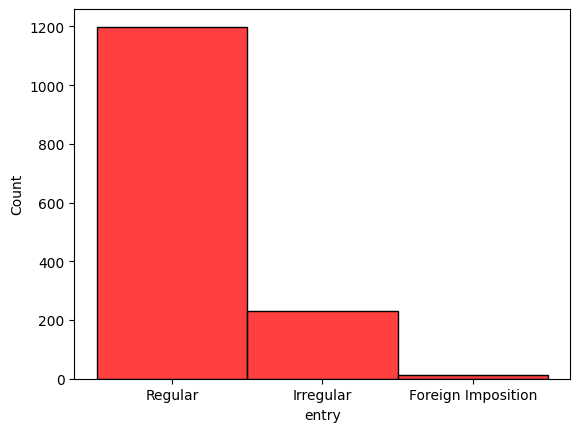

In [9]:
# fig.3
sns.histplot(data_all.entry, color='red')

<AxesSubplot: xlabel='Count', ylabel='exit'>

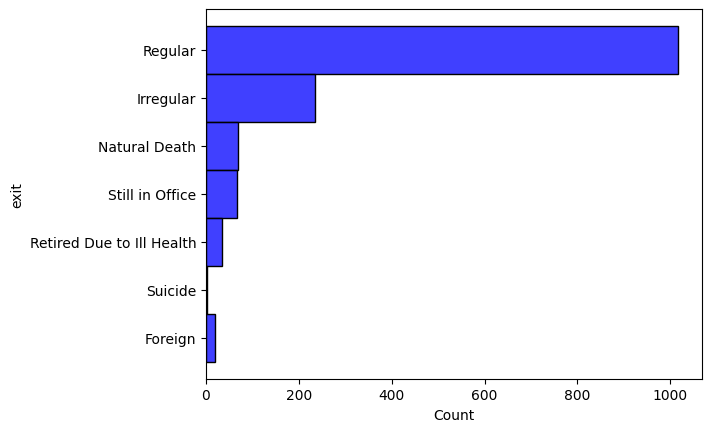

In [10]:
# fig.4
sns.histplot(data_all.exit, y = data_all.exit, color='blue')

<AxesSubplot: xlabel='age', ylabel='Count'>

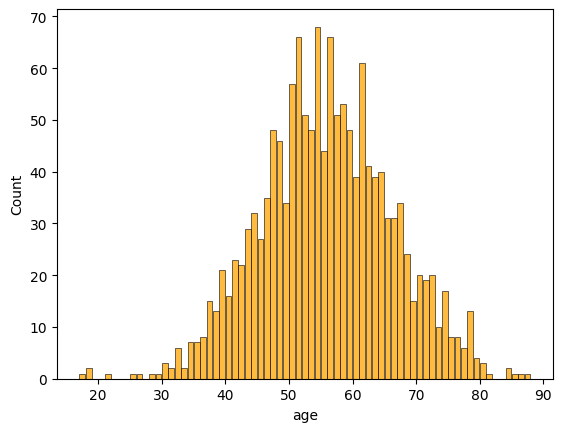

In [11]:
# See the distribution of age on Fig. 5
sns.histplot(data_all.age ,color = 'orange', shrink=.9, binwidth=1)

In [61]:
data_all['pop'].describe()

count    1.418000e+03
mean     3.800084e+04
std      1.228420e+05
min      1.344080e+02
25%      3.017000e+03
50%      8.085862e+03
75%      3.168320e+04
max      1.364827e+06
Name: pop, dtype: float64

In [59]:
data_all['begin_gdppc'] = np.log10(data_all['begin_gdppc'])

<AxesSubplot: xlabel='begin_gdppc', ylabel='Count'>

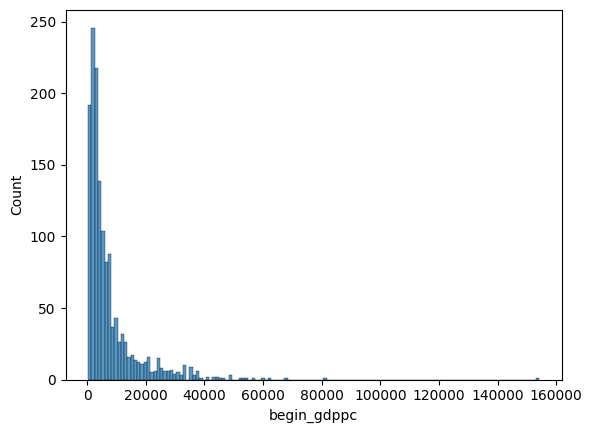

In [55]:
sns.histplot(data_all.begin_gdppc)

<AxesSubplot: xlabel='tenure', ylabel='Count'>

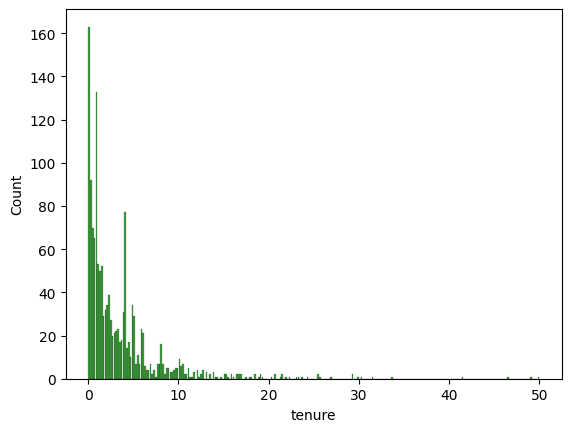

In [12]:
# See the distribution of tenure on fig. 6
sns.histplot(data_all.tenure, color = 'green', shrink=.9, binwidth=0.2)

0.020986997830823733
0.06925281173482664


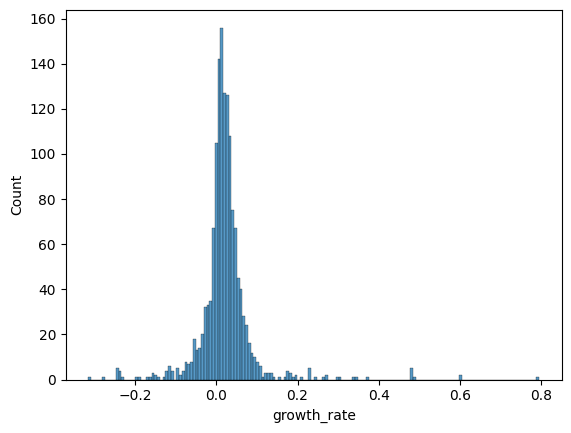

In [13]:
# Fig.7
# Look at the distribution of the data_all put into the model
ax = sns.histplot(data_all['growth_rate'])

mean = data_all['growth_rate'].mean()
std = data_all['growth_rate'].std()
print(mean)
print(std)

In [54]:
# Save dataset to CSV file
data_all.to_csv(r'./../Data/data_AutoGluon.csv', index = False)